<a href="https://colab.research.google.com/github/Prothoma2001/Real-Time-Bangla-Sign-Language-Recognition-Thesis-/blob/main/Real_Time_Sign_Language_Recognition_(Main_Code).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hybrid Transformer-based model

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import imageio
import cv2
from imutils import paths
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import seaborn as sns
from sklearn.metrics import confusion_matrix

from collections import namedtuple
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional
from torch import Tensor
from torch.hub import load_state_dict_from_url

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Training')
label_types = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Training')

print (label_types)  

['92', '91', '96', '97', '99', '94', '98', '95', '93', '90', '89', '84', '88', '85', '82', '83', '81', '86', '87', '9', '73', '77', '78', '80', '72', '74', '75', '8', '76', '79', '7', '69', '64', '63', '68', '65', '70', '67', '66', '71', '56', '61', '58', '6', '55', '62', '54', '59', '57', '60', '46', '45', '52', '48', '50', '47', '5', '49', '51', '53', '41', '36', '42', '39', '38', '40', '43', '37', '44', '4', '33', '34', '3', '31', '29', '30', '32', '35', '28', '27', '21', '20', '19', '2', '23', '18', '24', '22', '26', '25', '14', '12', '15', '16', '11', '10', '13', '1', '0', '17']


In [6]:
#preparing training data 

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Training' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/content/drive/MyDrive/OPS22 - Main Dataset/Training' + '/' +item) + '/' + room))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(train_df.head())
print(train_df.tail())

df = train_df.loc[:,['video_name','tag']]
df
df.to_csv('train.csv')

  tag                                         video_name
0  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
2  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
3  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
4  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
     tag                                         video_name
1582  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1583  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1584  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1585  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1586  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...


In [7]:
#Preparing Test Data

dataset_path = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Testing')
print(dataset_path)

room_types = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Testing')
print("Types of activities found: ", len(dataset_path))

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Testing' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/content/drive/MyDrive/OPS22 - Main Dataset/Testing' + '/' +item) + '/' + room))
    
# Build a dataframe        
test_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(test_df.head())
print(test_df.tail())

df = test_df.loc[:,['video_name','tag']]
df
df.to_csv('test.csv')

['91', '96', '94', '92', '93', '90', '95', '98', '97', '99', '86', '81', '82', '9', '89', '84', '85', '87', '83', '88', '73', '76', '79', '72', '77', '74', '78', '8', '75', '80', '68', '7', '69', '63', '66', '64', '67', '71', '70', '65', '59', '55', '61', '54', '62', '57', '58', '6', '60', '56', '47', '45', '49', '51', '48', '53', '5', '50', '46', '52', '38', '42', '37', '44', '43', '39', '4', '36', '40', '41', '32', '35', '29', '34', '33', '27', '31', '3', '30', '28', '18', '20', '25', '19', '2', '23', '26', '24', '21', '22', '14', '12', '16', '1', '17', '10', '13', '15', '0', '11']
Types of activities found:  100
  tag                                         video_name
0  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
1  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
2  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
3  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
4  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
    tag                            

In [189]:
MAX_SEQ_LENGTH = 300
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 7

In [9]:
#Data preparation

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 1587
Total videos for testing: 539


,Unnamed: 0,video_name,tag
633,633,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,56
1388,1388,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,26
274,274,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,86
993,993,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,39
1129,1129,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,3
883,883,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,5
814,814,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,52
231,231,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,82
691,691,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,55
712,712,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,62


In [190]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)



#Change
def build_feature_extractor(weights_path=None):
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=6144,activation="relu"))
    model.add(Dense(units=6144,activation="relu"))
    model.add(Dense(units=2, activation="softmax"))



feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.IntegerLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [191]:
!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!tar xf top5_data_prepared.tar.gz

In [184]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


In [192]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [193]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

Epoch 1/7
16/16 [==============================] - ETA: 0s - loss: 1.9951 - accuracy: 0.6647
Epoch 1: val_loss improved from inf to 1.00104, saving model to /tmp/video_classifier
16/16 [==============================] - 9s 493ms/step - loss: 1.9951 - accuracy: 0.6647 - val_loss: 1.0010 - val_accuracy: 0.4444
Epoch 2/7
16/16 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9504
Epoch 2: val_loss improved from 1.00104 to 0.53204, saving model to /tmp/video_classifier
16/16 [==============================] - 8s 474ms/step - loss: 0.1384 - accuracy: 0.9504 - val_loss: 0.5320 - val_accuracy: 0.8444
Epoch 3/7
16/16 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9980
Epoch 3: val_loss did not improve from 0.53204
16/16 [==============================] - 7s 454ms/step - loss: 0.0142 - accuracy: 0.9980 - val_loss: 1.7732 - val_accuracy: 0.4778
Epoch 4/7
16/16 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9980
Epoch 4: val

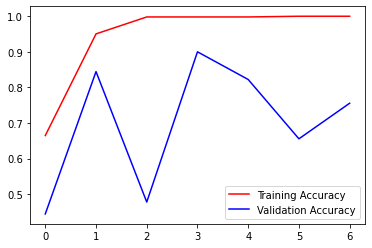

In [195]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


    plt.plot(history.history["accuracy"],'r', label="Training Accuracy")
    plt.plot(history.history["val_accuracy"],'b', label="Validation Accuracy")
    plt.legend()

    return history,model
    
trained_model = run_experiment() 

In [16]:
#sequence_model.save('model.h5')